# Import Librerie

In [670]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

# Definizione funzioni

In [671]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return torch.sqrt(torch.mean(torch.square(actual - predicted)))

In [672]:
def getRemoteDataset():
    return pd.read_csv('https://raw.githubusercontent.com/Uniba-dev-projects/forecasting-framework/master/synthetic_dataset.csv')    

In [673]:
def extractDataframeAndSeries(key, dataset):
    df = dataset[[key]]
    df = df.rename(columns={key: "t"}).reset_index()
    df.series = df.t.str.replace(",",".", regex=True).astype(float)
    return df, df.series.squeeze()

In [674]:
def calculateLoss(y, y_predicted):
    loss = []
    for i in range(len(y)):
        loss.append(abs(y[i]-y_predicted[i]))
    return loss

In [675]:
def showPerformanceGraph(label, portion, y_train, y_test, y_predicted_train, y_predicted_test, loss_train, loss_test, rmse_train, rmse_test):
    total = len(y_train) + len(y_test)
    plt.figure(figsize=(30,5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(0, total, 1), np.concatenate((y_train, y_test), axis=0))
    plt.plot(np.arange(0, total, 1), np.concatenate((y_predicted_train, y_predicted_test), axis=0))
    plt.axvline(x=total*portion, linestyle=":", color="red")
    plt.legend(["Series", "Predicted", "Train and test set splitter"])

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(0, total, 1), np.concatenate((loss_train, loss_test), axis=0))
    plt.axvline(x=total*portion, linestyle=":", color="red")
    plt.legend(["Loss", "Train and test set splitter"])

    plt.subplot(1, 3, 3)
    plt.plot(rmse_train)
    plt.plot(rmse_test)
    plt.title("Last RMSE Train = "+str(rmse_train[-1])+"\n Last RMSE Test = "+str(rmse_test[-1]))
    plt.legend(["RMSE Train", "RMSE Test"])
    
    plt.suptitle(label)

# Inizializzazione e Visualizazione Serie Temporali Sintentiche

In [676]:
dataset = getRemoteDataset()

In [677]:
_, series1 = extractDataframeAndSeries('y1(t) = t/1000 = y1(t-1)+0.001', dataset)
_, series2 = extractDataframeAndSeries('y2(t)=y2(t-1)*0.999', dataset)
_, series3 = extractDataframeAndSeries('y3(t)=y1(t)+y2(t)', dataset)
_, series4 = extractDataframeAndSeries('y4(t) = y4(t-1)-0.001', dataset)
_, series5 = extractDataframeAndSeries('y5(t)=y1(t)*t%2+y4(t)*(1-t%2)', dataset)

<AxesSubplot:xlabel='x', ylabel='y'>

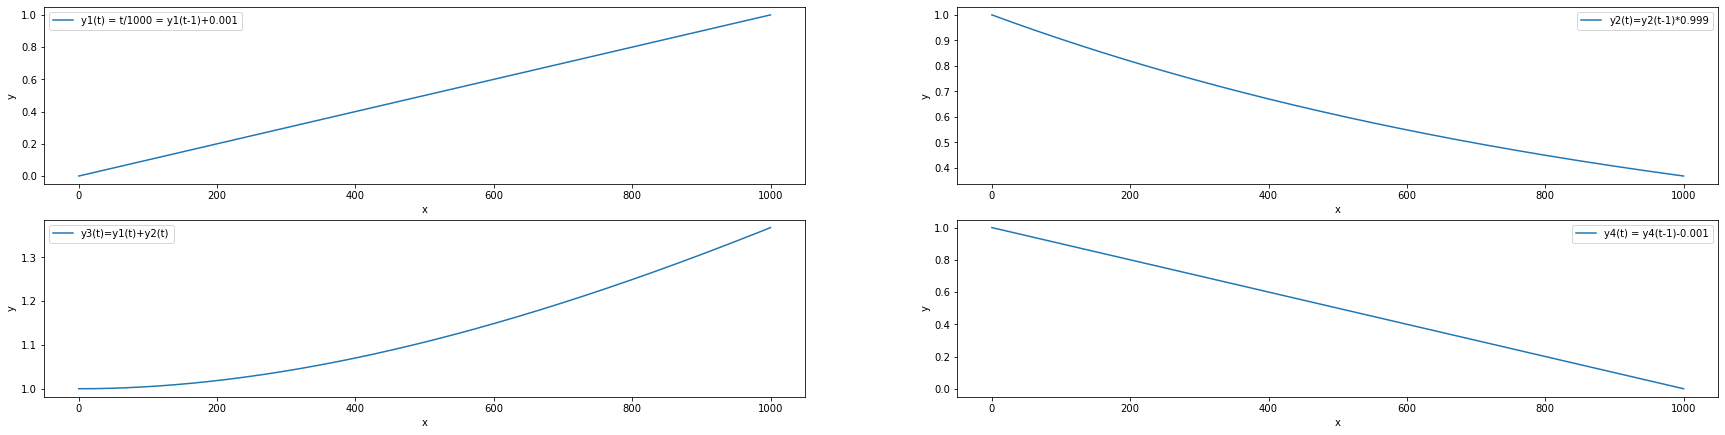

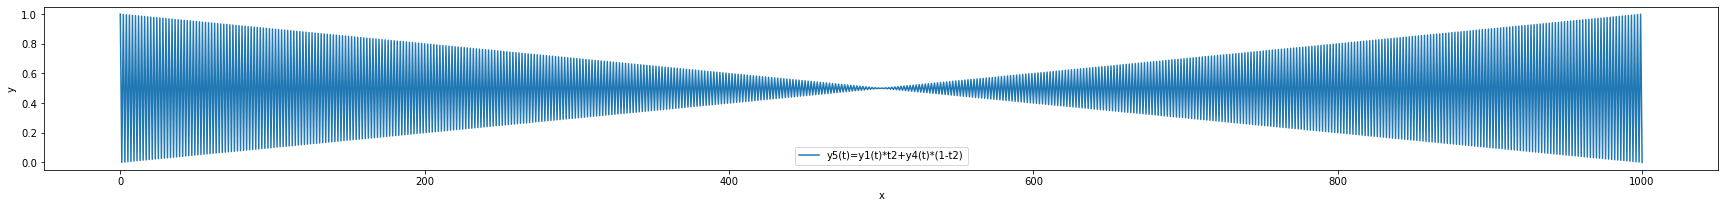

In [678]:
plt.figure(figsize=(30,15))

plt.subplot(4, 2, 1)
series1.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y1(t) = t/1000 = y1(t-1)+0.001")

plt.subplot(4, 2, 2)
series2.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y2(t)=y2(t-1)*0.999")

plt.subplot(4, 2, 3)
series3.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y3(t)=y1(t)+y2(t)")

plt.subplot(4, 2, 4)
series4.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y4(t) = y4(t-1)-0.001")

plt.figure(figsize=(30,3))
series5.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y5(t)=y1(t)*t2+y4(t)*(1-t2)")

# DatasetManager e Inizializzazione Fully Connected Neural Network
DatasetManager restituisce da una serie temporale un pandas.DataFrame definendo il nuemro di feature e il numero di variabili target.

In [679]:
class DatasetManager():
    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        dfTemp.ref = dfTemp.ref.astype(float)
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)
    
        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])
    
    def __getScaledDataFrame(self, df):
        tempColumns = df.columns
        scaler = MinMaxScaler()
        scalerDf = scaler.fit(df.to_numpy())
        df_scaled = scalerDf.transform(df)
        return pd.DataFrame(df_scaled, columns=tempColumns)

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.8):
        self.sequences = sequences
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        tempDf = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)
        self.df = self.__getScaledDataFrame(tempDf)

    def __len__(self):
        return len(self.sequences)

    def __train_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return xCol[0: int(len(self.sequences)*self.portion)], yCol[0: int(len(self.sequences)*self.portion)]
    
    def __test_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return  xCol[int(self.df['t'].size*self.portion):], yCol[int(self.df['t'].size*self.portion):]


In [680]:
class FCNN_Predictor(torch.nn.Module):
    def __init__(self, n_inp, l_1 = 180, l_2 = 48, conv1_out = 6, conv1_kernel = 36, conv2_kernel = 12, drop1 = .1, n_out = 1):
        super(FCNN_Predictor, self).__init__()
        self.dropout_lin1 = drop1
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv1 = nn.Conv1d(
            in_channels = 1,
            out_channels = conv1_out,
            kernel_size = conv1_kernel,
            padding = conv1_kernel - 1
        )
        self.conv2 = nn.Conv1d(
            in_channels = conv1_out,
            out_channels = conv1_out * 2,
            kernel_size = conv2_kernel,
            padding = conv2_kernel - 1
        )
        feature_tensor = self.fe_stack(torch.Tensor([[0]*n_inp]))
        # self.lin1 = nn.Linear(feature_tensor.size()[1], l_1)
        self.lin2 = nn.Linear(feature_tensor.size()[1], l_2)
        self.lin3 = nn.Linear(l_2, n_out)
        
    def fe_stack(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.flatten(start_dim = 1)
        return x

    def dm_stack(self, x):
        # x1 = F.relu(self.lin1(x))
        x2 = F.relu(self.lin2(x))
        y = self.lin3(x2)
        return y

    def forward(self, x):
        x = self.fe_stack(x)
        y = self.dm_stack(x)
        return y

In [681]:
def train_NN_model(model, train_data, train_labels, test_data, test_labels, num_epochs, inference = 10, verbose=True):
    
    if torch.cuda.is_available():
        model.train()

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    for t in range(num_epochs):
        y_train_pred = model(train_data)
        loss = RMSE_Loss(train_labels, y_train_pred)

        with torch.no_grad():
            y_test_pred = model(test_data[:-inference])
            test_loss = RMSE_Loss(test_labels[:-inference], y_test_pred)
        test_hist[t] = test_loss.item()

        if t % 10==0 and verbose is True:
            print(f'Epoch {t} train loss:{loss.item()} test loss: {test_loss.item()}')
        
        train_hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return model.eval(), train_hist, test_hist, y_test_pred, y_train_pred

In [682]:
def executeFCNN(label, series, feature_sequences=1, target_sequences=1, portion=0.8, offset=0, num_epochs=25, iterations=1):
    dataset = DatasetManager(
        series,
        features_sequences=feature_sequences,
        target_sequences=target_sequences,
        portion=portion,
        offset=offset
    )
    x_train, y_train = dataset.__train_set__()
    x_test, y_test = dataset.__test_set__()

    x_train_tensor = torch.tensor(data=x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(data=y_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(data=x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(data=y_test, dtype=torch.float32)


    print(''.join(['> ' for i in range(50)]))
    print(f'\n{"EPOCH":<15}{"TRAINING RMSE":<18}{"TESTING RMSE":<18}\n')
    print(''.join(['> ' for i in range(50)]))
    net = FCNN_Predictor(n_inp = feature_sequences, l_1 = 180).to("cpu")   
    rmse_TRAIN = []
    rmse_TEST = []
    x_trainDf2 = torch.tensor(data=x_train_tensor, dtype=torch.float32)
    y_trainDf2 = torch.tensor(data=y_train_tensor, dtype=torch.float32)
    x_testDf2 = torch.tensor(data=x_test_tensor, dtype=torch.float32)
    y_testDf2 = torch.tensor(data=y_test_tensor, dtype=torch.float32)

    for i in range(iterations):
        model, train_hist, test_hist, y_pred, y_pred_train, = train_NN_model(net, x_trainDf2, y_trainDf2, x_testDf2, y_testDf2, num_epochs=num_epochs, verbose=False)
        rmse_TEST.append(test_hist[num_epochs-1])
        rmse_TRAIN.append(train_hist[num_epochs-1])
        print(f'{(iterations - i):>3}) {str(num_epochs):<15}{train_hist[num_epochs-1]:<18.3f}{test_hist[num_epochs-1]:<18.3f}')
        
    
    showPerformanceGraph(
        label = label,
        portion=portion,
        y_train=y_train.squeeze(),
        y_test=y_test.squeeze()[:-10],
        y_predicted_train=y_pred_train.detach().numpy().flatten(),
        y_predicted_test=y_pred.detach().numpy().flatten(),
        loss_train=calculateLoss(y_train.squeeze(), y_pred_train.detach().numpy().flatten()),
        loss_test=calculateLoss(y_test.squeeze()[:-10], y_pred.detach().numpy().flatten()),
        rmse_train=rmse_TRAIN,
        rmse_test=rmse_TEST
    )

# Esecuzione Fully Connected Neural Network

In [683]:
features_length = 5 #Default 1 (Sostituire i valori per gli esperimenti)
offset = 3 #Default 0 (Sostituire i valori per gli esperimenti)
portion_train_test = 0.8 #Default 0.8 (Sostituire i valori per gli esperimenti)
num_epochs = 100
max_iter = 20

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 100            0.009             0.004             
 19) 100            0.003             0.005             
 18) 100            0.004             0.007             
 17) 100            0.002             0.003             
 16) 100            0.004             0.007             
 15) 100            0.003             0.008             
 14) 100            0.002             0.004             
 13) 100            0.001             0.002             
 12) 100            0.008             0.013             
 11) 100            0.002             0.004             
 10) 100            0.001             0.001             
  9) 100            0.002             0.001             
  8) 100            0.007             0.015             
  7

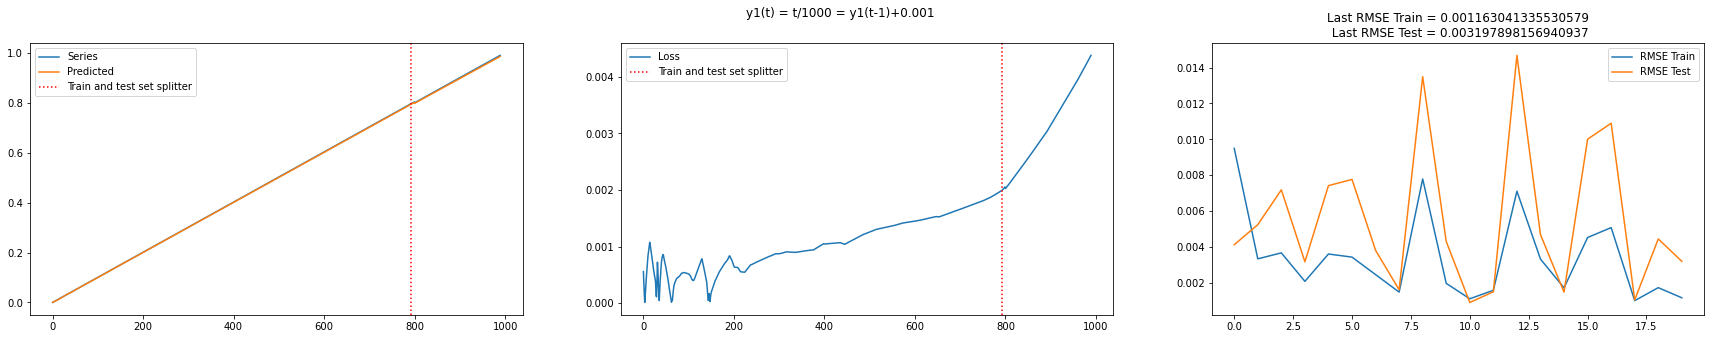

In [684]:
executeFCNN("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 100            0.004             0.071             
 19) 100            0.003             0.061             
 18) 100            0.001             0.056             
 17) 100            0.002             0.052             
 16) 100            0.003             0.051             
 15) 100            0.004             0.048             
 14) 100            0.004             0.047             
 13) 100            0.004             0.047             
 12) 100            0.002             0.047             
 11) 100            0.002             0.047             
 10) 100            0.001             0.047             
  9) 100            0.002             0.046             
  8) 100            0.000             0.045             
  7

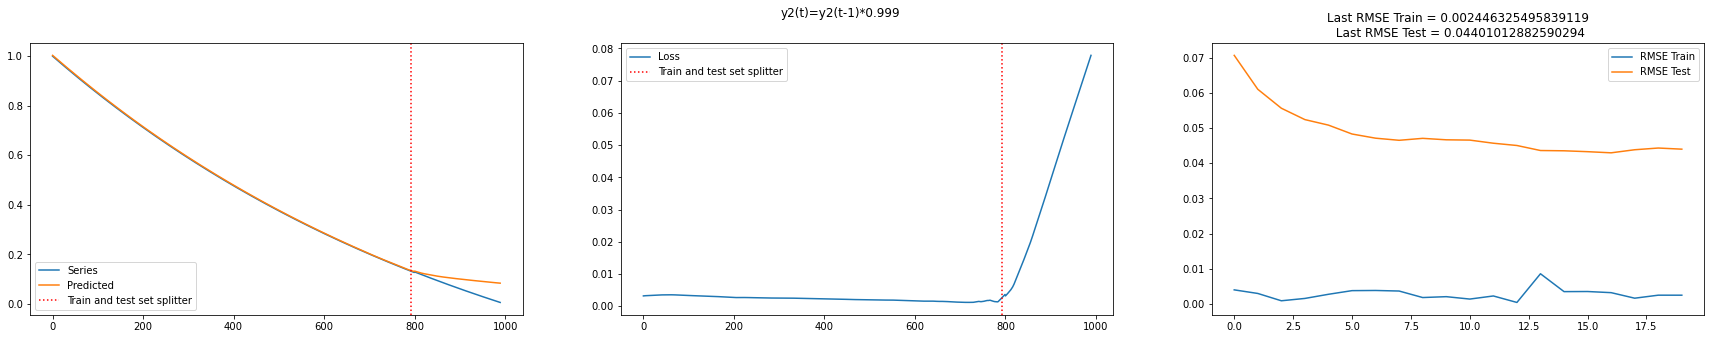

In [685]:
executeFCNN("y2(t)=y2(t-1)*0.999", series2, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 100            0.002             0.014             
 19) 100            0.003             0.012             
 18) 100            0.003             0.005             
 17) 100            0.004             0.014             
 16) 100            0.001             0.005             
 15) 100            0.001             0.006             
 14) 100            0.003             0.014             
 13) 100            0.001             0.005             
 12) 100            0.002             0.012             
 11) 100            0.007             0.024             
 10) 100            0.001             0.007             
  9) 100            0.001             0.012             
  8) 100            0.005             0.021             
  7

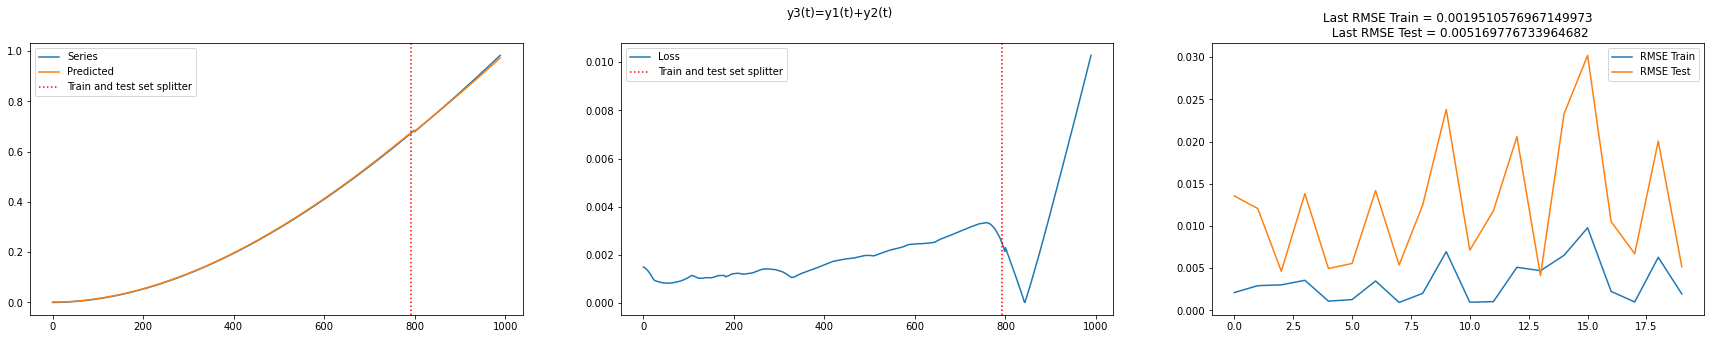

In [686]:
executeFCNN("y3(t)=y1(t)+y2(t)", series3, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 100            0.005             0.089             
 19) 100            0.004             0.079             
 18) 100            0.002             0.072             
 17) 100            0.012             0.072             
 16) 100            0.005             0.067             
 15) 100            0.005             0.066             
 14) 100            0.003             0.067             
 13) 100            0.009             0.064             
 12) 100            0.001             0.066             
 11) 100            0.001             0.067             
 10) 100            0.005             0.066             
  9) 100            0.005             0.066             
  8) 100            0.004             0.068             
  7

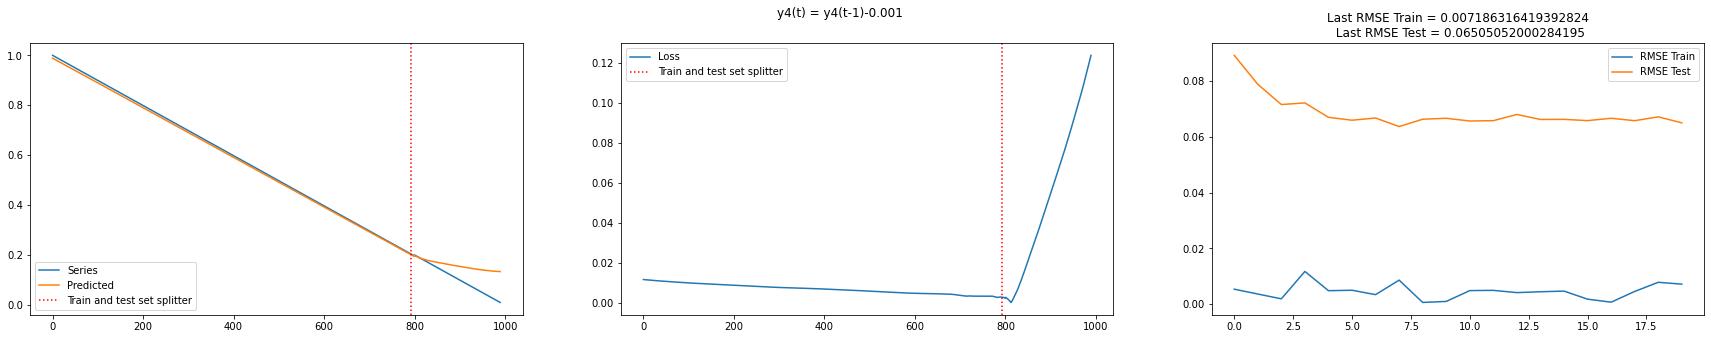

In [687]:
executeFCNN("y4(t) = y4(t-1)-0.001", series4, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 100            0.020             0.033             
 19) 100            0.009             0.017             
 18) 100            0.006             0.011             
 17) 100            0.005             0.008             
 16) 100            0.003             0.006             
 15) 100            0.004             0.006             
 14) 100            0.003             0.005             
 13) 100            0.006             0.008             
 12) 100            0.005             0.007             
 11) 100            0.005             0.007             
 10) 100            0.005             0.007             
  9) 100            0.004             0.006             
  8) 100            0.003             0.005             
  7

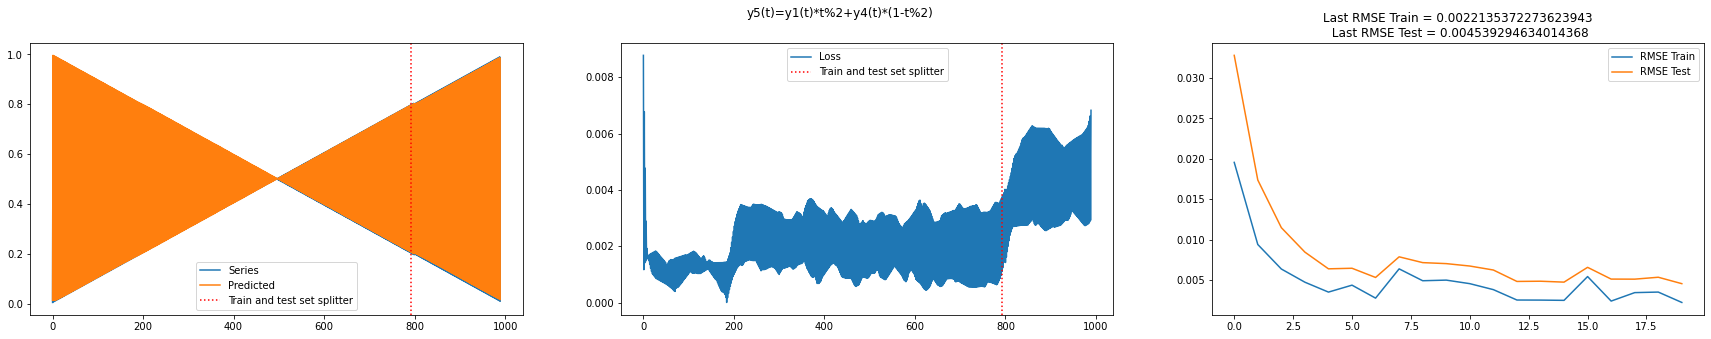

In [688]:
executeFCNN("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)